# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project...

TODO:
-Aggiungere funzione per trovare correlazione tra features
-Considerare il fatto che il diabete causa durezza della pella, ma quest'ultima non è direttamente causa di diabete (=> != <=>)+
-Piccola spiegazione del ragionamento dietro le correlazioni NON trovate
-Fattore di rischio
-


In [4]:
%pip install pgmpy

Note: you may need to restart the kernel to use updated packages.


## Dataset

768 rows, 9 columns

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.

From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
pd.__version__

'1.5.1'

## Exploratory Data Analysis

In [49]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [50]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In our dataset there are 268 patients with diabetes and 500 without. The classes are imbalanced: only about 35% of the entries have diabetes.

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_1756/2705674253.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_1756/2705674253.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

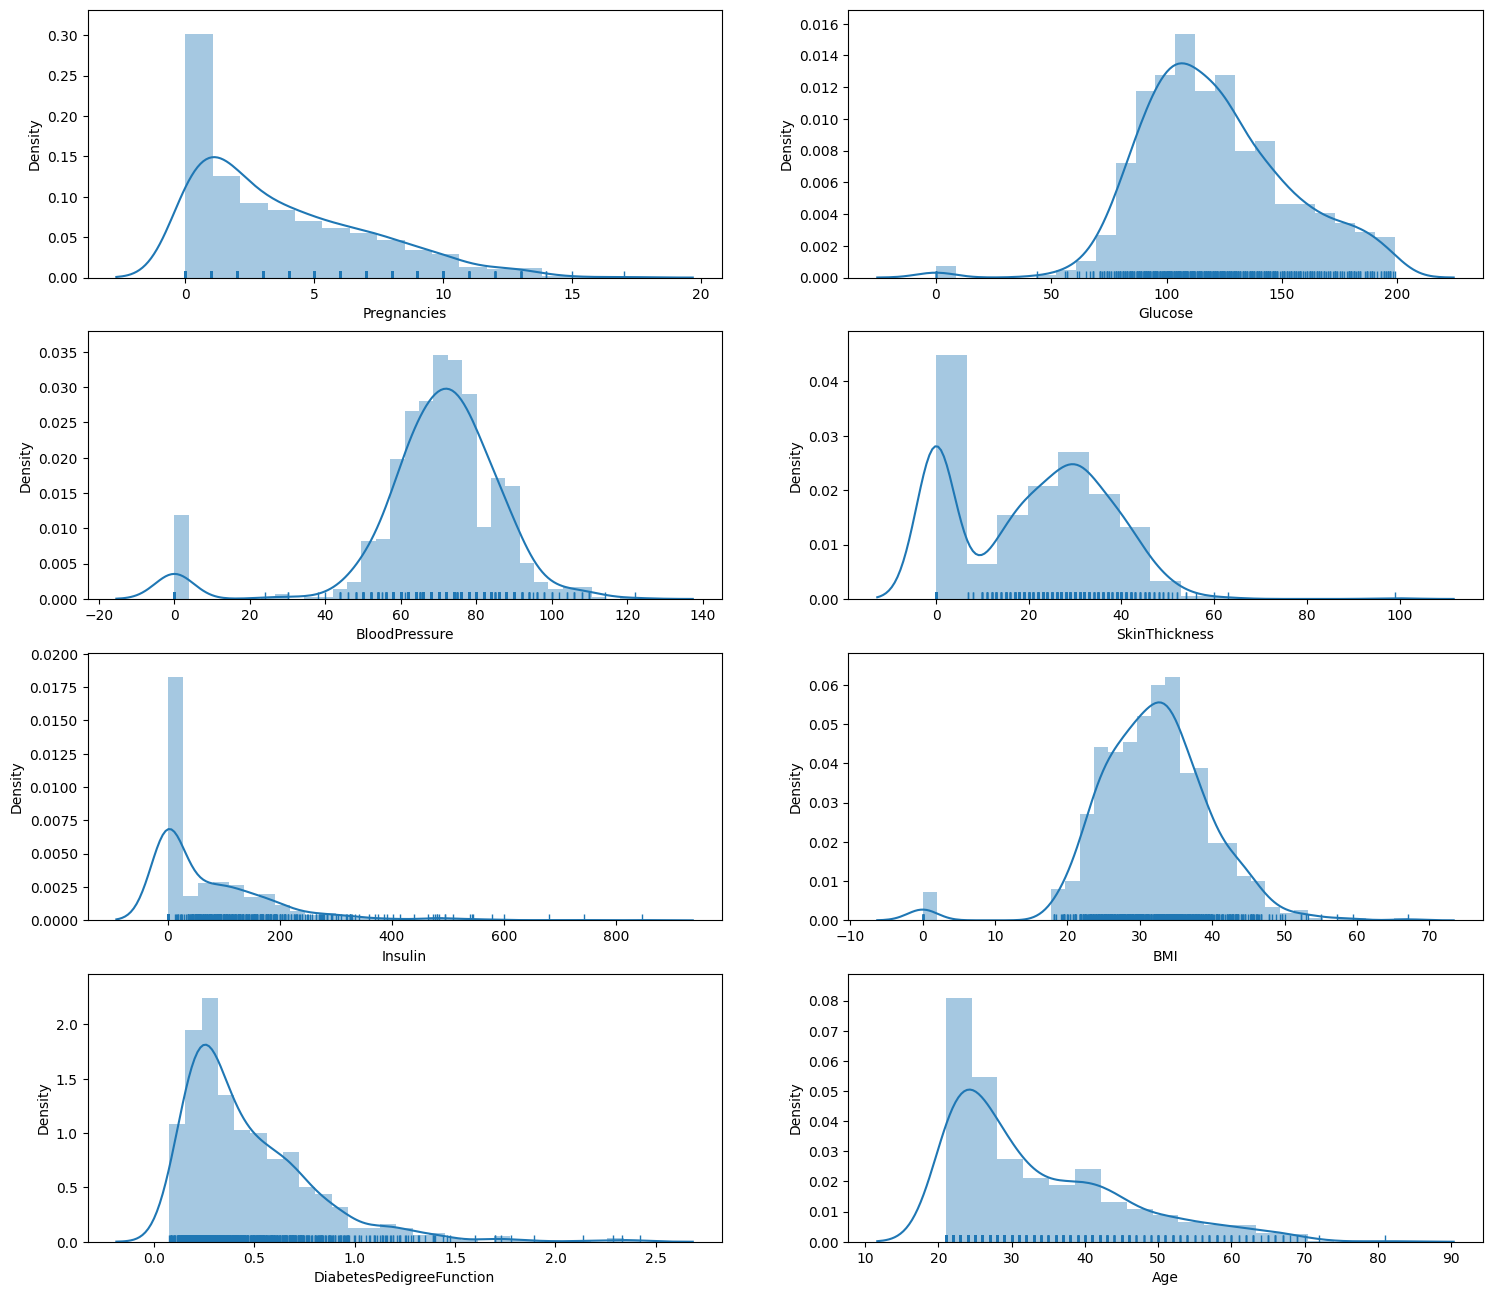

In [9]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

In [10]:
df_raw.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Vediamo che il dataset è sbilanciato

In [11]:
print("Numero di outcome seza diabete", (df_raw["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_raw["Outcome"] == 1).sum())

Numero di outcome seza diabete 500
Numero di outcome con diabete 268


Vediamo che ci sono tanti valori nulli nel dataset. Sarebbero da togliere dato che sono dei NaN. Allo stesso tempo possiamo usare questa cosa per iniziare un downsample dei dati con Outcome '0'

In [12]:
for item in df_raw.columns:
    counter = 0
    for i in range(len(df_raw[item])):
        if df_raw[item][i] == 0 and df_raw["Outcome"][i] == 0:
            counter += 1
    print("nella colonna", item,"ci sono ",counter,"righe da eliminare che possono semplicemente essere downsamplate")

nella colonna Pregnancies ci sono  73 righe da eliminare che possono semplicemente essere downsamplate
nella colonna Glucose ci sono  3 righe da eliminare che possono semplicemente essere downsamplate
nella colonna BloodPressure ci sono  19 righe da eliminare che possono semplicemente essere downsamplate
nella colonna SkinThickness ci sono  139 righe da eliminare che possono semplicemente essere downsamplate
nella colonna Insulin ci sono  236 righe da eliminare che possono semplicemente essere downsamplate
nella colonna BMI ci sono  9 righe da eliminare che possono semplicemente essere downsamplate
nella colonna DiabetesPedigreeFunction ci sono  0 righe da eliminare che possono semplicemente essere downsamplate
nella colonna Age ci sono  0 righe da eliminare che possono semplicemente essere downsamplate
nella colonna Outcome ci sono  500 righe da eliminare che possono semplicemente essere downsamplate


In [13]:
for item in df_raw.columns:
    print("valori di ",item)
    temp = df_raw[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")
    #
    #chiedere a Sten dei bin sensati per questi valori

valori di  Pregnancies
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
----------------------
valori di  Glucose
[  0  44  56  57  61  62  65  67  68  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188
 189 190 191 193 194 195 196 197 198 199]
----------------------
valori di  BloodPressure
[  0  24  30  38  40  44  46  48  50  52  54  55  56  58  60  61  62  64
  65  66  68  70  72  74  75  76  78  80  82  84  85  86  88  90  92  94
  95  96  98 100 102 104 106 108 110 114 122]
----------------------
valori di  SkinThickness
[ 0  7  8 10 11 12 13 14 15 16 17 18 19 2

Togliamo le righe che hanno un valore nullo aka NaN e un outcome '0'

In [14]:
df_clean = df_raw.copy(deep=True)

In [15]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI','Age']
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 and df_clean["Outcome"][i] == 0:
            drop_list.append(i)
    print("SIUUUM")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)


SIUUUM
SIUUUM
SIUUUM
SIUUUM
SIUUUM
SIUUUM


In [16]:
df_clean.shape

(530, 9)

Abbiamo tolto un po di roba, adiamo sia a vedere se e quanto è sbilanciato il dataset che a togliere le restati righe che hanno un NaN

In [17]:
print("Numero di outcome seza diabete", (df_clean["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_clean["Outcome"] == 1).sum())

Numero di outcome seza diabete 262
Numero di outcome con diabete 268


Controllo sull'insulina e sul tipo di diabete

In [18]:
count_1 = 0
count_2 = 1
for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] < 1 and df_clean["Outcome"][i] == 1 :
        count_1 += 1
    if df_clean["Insulin"][i] > 200 and df_clean["Outcome"][i] == 1:
        count_2 += 1
print("presumibilmente ci sono ",count_1,"pazienti con diabete di tipo 1")
print("presumibilmente ci sono ",count_2,"pazienti con diabete di tipo 2")

presumibilmente ci sono  138 pazienti con diabete di tipo 1
presumibilmente ci sono  47 pazienti con diabete di tipo 2


Togliamo ora i restanti NaN senza però adare a toccare quelli dell'insulina ( presumiamo siano registrati nulli ) 

In [19]:
for item in df_clean.columns:
    print("    - nella colonna ", item," sono presenti questi zeri")
    print((df_clean[item] == 0).sum())

    - nella colonna  Pregnancies  sono presenti questi zeri
75
    - nella colonna  Glucose  sono presenti questi zeri
2
    - nella colonna  BloodPressure  sono presenti questi zeri
16
    - nella colonna  SkinThickness  sono presenti questi zeri
88
    - nella colonna  Insulin  sono presenti questi zeri
138
    - nella colonna  BMI  sono presenti questi zeri
2
    - nella colonna  DiabetesPedigreeFunction  sono presenti questi zeri
0
    - nella colonna  Age  sono presenti questi zeri
0
    - nella colonna  Outcome  sono presenti questi zeri
262


In [20]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI','Age']

for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("SIUUUM")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)

SIUUUM
SIUUUM
SIUUUM
SIUUUM
SIUUUM


Bene, andiamo a vedere cosa rimane del dataset originario

In [21]:
print("Numero di outcome seza diabete", (df_clean["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_clean["Outcome"] == 1).sum())

Numero di outcome seza diabete 262
Numero di outcome con diabete 177


Come notiamo c'è ancora da fare un downsample per bilanciare il dataset

In [22]:
from sklearn.utils import resample

In [23]:
df_positive_outcome = df_clean[df_clean["Outcome"] == 1]
df_negative_outcome = df_clean[df_clean["Outcome"] == 0]
#-----------

df_negative_outcome_downsampled = resample(df_negative_outcome,
             replace=True,
             n_samples=len(df_positive_outcome),
             random_state=42)
print(df_negative_outcome_downsampled.shape)
#-----------------

df_balanced = pd.concat([df_negative_outcome_downsampled, df_positive_outcome])
#-----------

df_balanced.reset_index(drop=True, inplace=True)

print("Numero di outcome seza diabete", (df_balanced["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_balanced["Outcome"] == 1).sum())


(177, 9)
Numero di outcome seza diabete 177
Numero di outcome con diabete 177


Bene, ora il dataset è bilanciato, non resta che binnarizzarlo

In [24]:
for item in df_balanced:
    print("valori di ",item)
    temp = df_balanced[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

valori di  Pregnancies
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
----------------------
valori di  Glucose
[ 75  78  79  80  81  82  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 154 155 156 157 158 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 179 180 181 184 186 187 188 189 193 194 195
 196 197 198 199]
----------------------
valori di  BloodPressure
[ 30  38  40  44  46  48  50  52  54  56  58  60  62  64  65  66  68  70
  72  74  76  78  80  82  84  85  86  88  90  92  94  98 100 102 104 106
 110]
----------------------
valori di  SkinThickness
[ 7  8 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 56 60 63 99]
----------------------
valori d

In [25]:
df_bin = df_balanced.copy(deep=True)

In [26]:
df_bin.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,95,60,18,58,23.9,0.260,22,0
1,8,126,88,36,108,38.5,0.349,49,0
2,9,124,70,33,402,35.4,0.282,34,0
3,1,84,64,23,115,36.9,0.471,28,0
4,2,110,74,29,125,32.4,0.698,27,0


In [27]:
#primo approccio alla binnerizzazione, molto manaccione ma funziona. Sotto un apporccio più pulito

"""df_bin["Pregnancies"] = pd.cut(x=df_balanced["Pregnancies"], bins=[-1,3,6,11,18],
                        labels=["0-3","3-6","6-11","11+"])

df_bin["Glucose"] = pd.cut(x=df_balanced["Glucose"], bins=[70,100,140,np.max(df_balanced["Glucose"])],
                        labels=["70-100","100-140","140-200"])

df_bin["BloodPressure"] = pd.cut(x=df_balanced["BloodPressure"], bins=[29,60,80,85,90,100,110],
                        labels=["30-60","60-80","80-85","85-90","90-100","100-110"])

df_bin["SkinThickness"] = pd.cut(x=df_balanced["SkinThickness"], bins=[6,15,30,40,np.max(df_balanced["SkinThickness"])],
                        labels=["7,15","15,30","30-40","40+"])

df_bin["Insulin"] = pd.cut(x=df_balanced["Insulin"], bins=[-1,25,50,120,150,250,np.max(df_balanced["Insulin"])],
                        labels=["0-25","25-50","50-120","120-150","150-250","250+"])

df_bin["BMI"] = pd.cut(x=df_balanced["BMI"], bins=[19,25,30,np.max(df_balanced["BMI"])],
                        labels=["19-25","25-30","30+"])

df_bin["DiabetesPedigreeFunction"] = pd.cut(x=df_balanced["DiabetesPedigreeFunction"], bins=[-1,0.2,0.3,0.5,0.7,0.9,np.max(df_balanced["DiabetesPedigreeFunction"])],
                        labels=["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"])

df_bin["Age"] = pd.cut(x=df_balanced["Age"], bins=[20,30,40,50,60,np.max(df_balanced["Age"])],
                        labels=["20-30","30-40","40-50","50-60","60+"])
"""

'df_bin["Pregnancies"] = pd.cut(x=df_balanced["Pregnancies"], bins=[-1,3,6,11,18],\n                        labels=["0-3","3-6","6-11","11+"])\n\ndf_bin["Glucose"] = pd.cut(x=df_balanced["Glucose"], bins=[70,100,140,np.max(df_balanced["Glucose"])],\n                        labels=["70-100","100-140","140-200"])\n\ndf_bin["BloodPressure"] = pd.cut(x=df_balanced["BloodPressure"], bins=[29,60,80,85,90,100,110],\n                        labels=["30-60","60-80","80-85","85-90","90-100","100-110"])\n\ndf_bin["SkinThickness"] = pd.cut(x=df_balanced["SkinThickness"], bins=[6,15,30,40,np.max(df_balanced["SkinThickness"])],\n                        labels=["7,15","15,30","30-40","40+"])\n\ndf_bin["Insulin"] = pd.cut(x=df_balanced["Insulin"], bins=[-1,25,50,120,150,250,np.max(df_balanced["Insulin"])],\n                        labels=["0-25","25-50","50-120","120-150","150-250","250+"])\n\ndf_bin["BMI"] = pd.cut(x=df_balanced["BMI"], bins=[19,25,30,np.max(df_balanced["BMI"])],\n                   

In [28]:
#dictionary di configurazione per la binnerizzazione

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,11,18],
            "labels": ["0-3","3-6","6-11","11+"]},

        "Glucose" :{
            "bins" : [70,100,140,np.max(df_balanced["Glucose"])],
            "labels" : ["70-100","100-140","140-200"]},

        "BloodPressure" :{
            "bins" : [29,60,80,85,90,100,110],
            "labels" : ["30-60","60-80","80-85","85-90","90-100","100-110"]},

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_balanced["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,25,50,120,150,250,np.max(df_balanced["Insulin"])],
            "labels" : ["0-25","25-50","50-120","120-150","150-250","250+"]},
            
        "BMI" :{
            "bins" : [19,25,30,np.max(df_balanced["BMI"])],
            "labels" : ["19-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_balanced["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_balanced["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [29]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_balanced[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

In [30]:
for item in df_bin:
    print("valori di ",item)
    temp = df_bin[item].unique()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")

valori di  Pregnancies
['0-3', '6-11', '3-6', '11+']
Categories (4, object): ['0-3' < '3-6' < '6-11' < '11+']
----------------------
valori di  Glucose
['70-100', '100-140', '140-200']
Categories (3, object): ['70-100' < '100-140' < '140-200']
----------------------
valori di  BloodPressure
['30-60', '85-90', '60-80', '80-85', '90-100', '100-110']
Categories (6, object): ['30-60' < '60-80' < '80-85' < '85-90' < '90-100' < '100-110']
----------------------
valori di  SkinThickness
['15-30', '30-40', '7-15', '40+']
Categories (4, object): ['7-15' < '15-30' < '30-40' < '40+']
----------------------
valori di  Insulin
['50-120', '250+', '120-150', '150-250', '25-50', '0-25']
Categories (6, object): ['0-25' < '25-50' < '50-120' < '120-150' < '150-250' < '250+']
----------------------
valori di  BMI
['19-25', '30+', '25-30']
Categories (3, object): ['19-25' < '25-30' < '30+']
----------------------
valori di  DiabetesPedigreeFunction
['0.2-0.3', '0.3-0.5', '0.5-0.7', '0.9+', '0-0.2', '0.7-0.

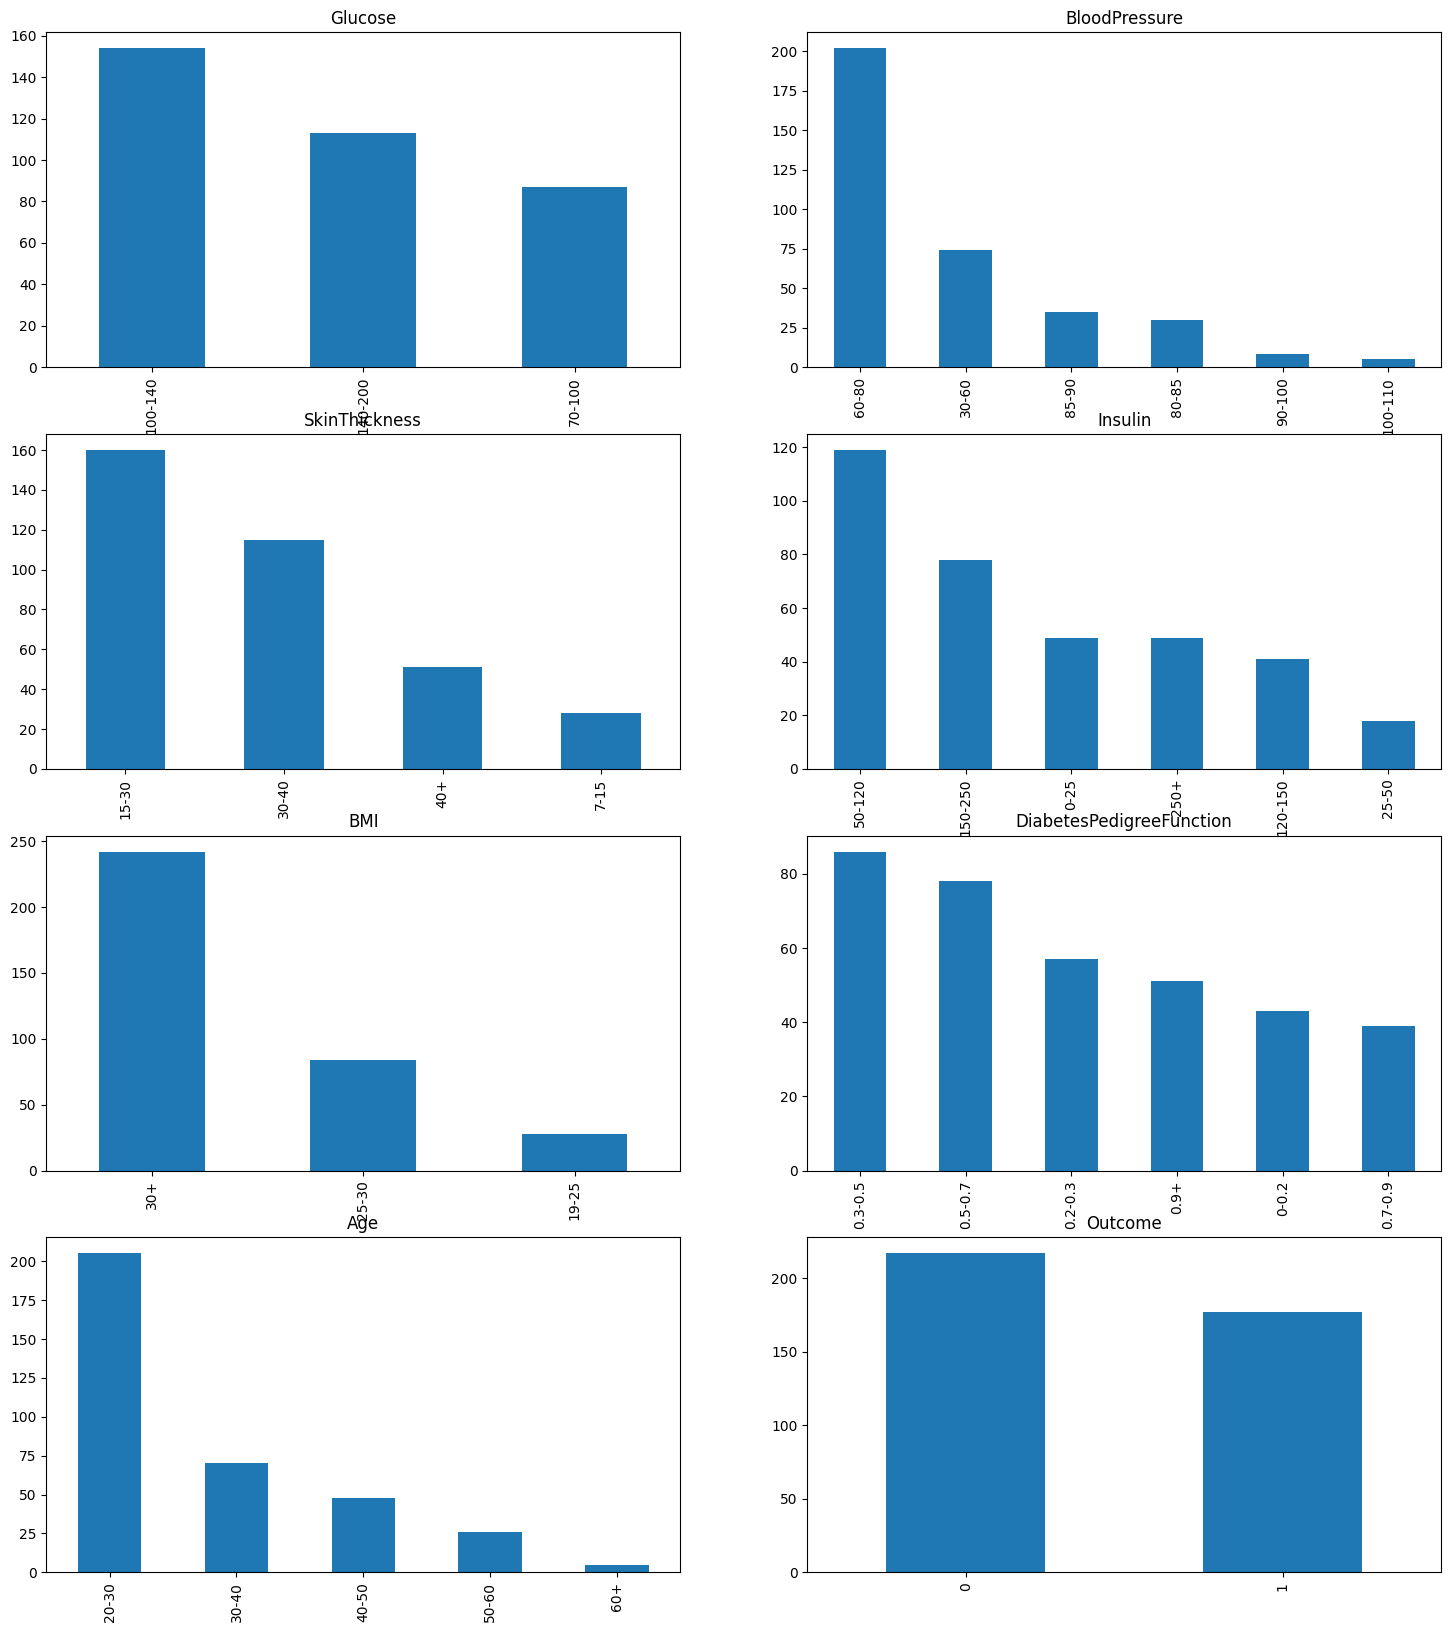

In [31]:
#Visualization of the binerized features distributions

fig, axs = plt.subplots(4, 2, figsize=(18,20))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1])


I bin sono stati creati correttamente

## Network


"In this chapter both the structure of the network, created from scratch by analyzing scientific papers related to the topic, and the parameter learning process are taken into account.

In particular, a variety of methods related to the analysis of Bayesian Networks are explored."

### Showing the network

A graphical preliminary overview of the network is shown using the visual library of pgmpy, the acronyms related to dataset attributes are the followings:

...


In [32]:
%pip install daft

Note: you may need to restart the kernel to use updated packages.


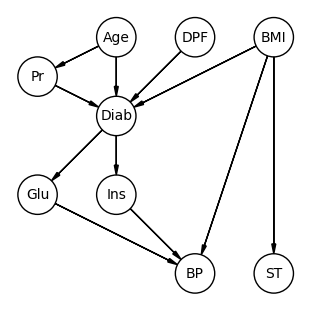

In [80]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 4))
pgm.add_node(daft.Node('DPF', "DPF", 3, 4))
pgm.add_node(daft.Node('BMI', "BMI", 4, 4))

pgm.add_node(daft.Node('Pr', "Pr", 1, 3.5))

pgm.add_node(daft.Node('Diab', "Diab", 2, 3))

pgm.add_node(daft.Node('Glu', "Glu", 1, 2))
pgm.add_node(daft.Node('Ins', "Ins", 2, 2))

pgm.add_node(daft.Node('BP', "BP", 3, 1))
pgm.add_node(daft.Node('ST', "ST", 4, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab')
pgm.add_edge('DPF', 'Diab')
pgm.add_edge('Age', 'Diab')
pgm.add_edge('BMI','Diab')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab', 'Glu')
pgm.add_edge('Diab', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Ins', 'BP')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [81]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('Age','Pregnancies'),('Pregnancies', 'Diabetes'),('DiabetesPedigreeFunction', 'Diabetes'),('Age', 'Diabetes'),('BMI','Diabetes'),
('BMI','SkinThickness'),('BMI', 'BloodPressure'),('Diabetes', 'Glucose'),('Diabetes', 'Insulin'),('Glucose', 'BloodPressure'),('Insulin','BloodPressure')])

###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [82]:
# Showing all the nodes of the model
model.nodes()

NodeView(('Age', 'Pregnancies', 'Diabetes', 'DiabetesPedigreeFunction', 'BMI', 'SkinThickness', 'BloodPressure', 'Glucose', 'Insulin'))

In [83]:
# Showing all the edges of the model
model.edges()

OutEdgeView([('Age', 'Pregnancies'), ('Age', 'Diabetes'), ('Pregnancies', 'Diabetes'), ('Diabetes', 'Glucose'), ('Diabetes', 'Insulin'), ('DiabetesPedigreeFunction', 'Diabetes'), ('BMI', 'Diabetes'), ('BMI', 'SkinThickness'), ('BMI', 'BloodPressure'), ('Glucose', 'BloodPressure'), ('Insulin', 'BloodPressure')])

In [84]:
# Local independecies of a single node
model.local_independencies("Diabetes")

(Diabetes ⟂ SkinThickness | DiabetesPedigreeFunction, Age, BMI, Pregnancies)

In [85]:
model.local_independencies("SkinThickness")

(SkinThickness ⟂ DiabetesPedigreeFunction, Age, Diabetes, Insulin, Glucose, BloodPressure, Pregnancies | BMI)

In [86]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("Glucose", "Insuline"))
print(model.is_dconnected("Glucose", "Insuline",observed=["Diabetes"] ))

False
False


In [87]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with resepect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with resepect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insuline", "Diabetes")

Node Glucose is irrelevant with resepect to Insuline given the evidence Diabetes


In [88]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes')

{'BloodPressure': {'Age',
  'BMI',
  'BloodPressure',
  'DiabetesPedigreeFunction',
  'Glucose',
  'Insulin',
  'Pregnancies',
  'SkinThickness'}}

In [89]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

['Insulin', 'Glucose', 'BMI']

### Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [43]:
from pgmpy.estimators import BayesianEstimator

In [46]:
df = df_bin.rename(columns = {'Outcome':'Diabetes'}) #column names and node names must be the same

In [47]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
0,0-3,70-100,30-60,15-30,50-120,19-25,0.2-0.3,20-30,0
1,6-11,100-140,85-90,30-40,50-120,30+,0.3-0.5,40-50,0
2,6-11,100-140,60-80,30-40,250+,30+,0.2-0.3,30-40,0
3,0-3,70-100,60-80,15-30,50-120,30+,0.3-0.5,20-30,0
4,0-3,100-140,60-80,15-30,120-150,30+,0.5-0.7,20-30,0


In [91]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of Age:
+------------+-----------+
| Age(20-30) | 0.573816  |
+------------+-----------+
| Age(30-40) | 0.197772  |
+------------+-----------+
| Age(40-50) | 0.13649   |
+------------+-----------+
| Age(50-60) | 0.0752089 |
+------------+-----------+
| Age(60+)   | 0.0167131 |
+------------+-----------+ 

CPT of Pregnancies:
+-------------------+-----+----------------------+
| Age               | ... | Age(60+)             |
+-------------------+-----+----------------------+
| Pregnancies(0-3)  | ... | 0.20833333333333334  |
+-------------------+-----+----------------------+
| Pregnancies(11+)  | ... | 0.041666666666666664 |
+-------------------+-----+----------------------+
| Pregnancies(3-6)  | ... | 0.20833333333333334  |
+-------------------+-----+----------------------+
| Pregnancies(6-11) | ... | 0.5416666666666666   |
+-------------------+-----+----------------------+ 

CPT of Diabetes:
+--------------------------+-----+--------------------------------+
| Age                

In [93]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

True

In [92]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'Age': 5,
             'Pregnancies': 4,
             'Diabetes': 2,
             'DiabetesPedigreeFunction': 6,
             'BMI': 3,
             'SkinThickness': 4,
             'BloodPressure': 6,
             'Glucose': 3,
             'Insulin': 6})

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [98]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [99]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies
print('Probability of having diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '0-3'}))

print('Probability of having diabetes with more than 11 pregnancies:')
print(infer.query(["Diabetes"],evidence={"Pregnancies": '11+'}))

Probability of having diabetes with 0 to 3 pregnancies:
+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.5797 |
+-------------+-----------------+
| Diabetes(1) |          0.4203 |
+-------------+-----------------+
Probability of having diabetes with more than 11 pregnancies:
+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.3647 |
+-------------+-----------------+
| Diabetes(1) |          0.6353 |
+-------------+-----------------+


In [100]:
#Evidential inference (explanation): probability of having diabetes given that the patient has very high insulin level
print(infer.query(["Diabetes"],evidence={"Insulin": '250+'}))

+-------------+-----------------+
| Diabetes    |   phi(Diabetes) |
+=============+=================+
| Diabetes(0) |          0.4047 |
+-------------+-----------------+
| Diabetes(1) |          0.5953 |
+-------------+-----------------+


In [101]:
#Intercausal inference (explaining away): why she has high blood pressure given the fact that she hasn't diabetes
print(infer.query(["BMI"],evidence={"BloodPressure": '100-110' , "Diabetes": 0}))

+------------+------------+
| BMI        |   phi(BMI) |
+============+============+
| BMI(19-25) |     0.1628 |
+------------+------------+
| BMI(25-30) |     0.3293 |
+------------+------------+
| BMI(30+)   |     0.5078 |
+------------+------------+


The maximum a posteriori (MAP) queries boil down to finding the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variables), given observations of some evidence variables. This is sometimes also referred to as partial abductive inference.

The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [102]:
#Infer MAP queries
print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '70-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes': 1}))

Eliminating: Pregnancies: 100%|██████████| 5/5 [00:00<00:00, 362.53it/s]    


{'Insulin': '50-120'}


Eliminating: Diabetes: 100%|██████████| 5/5 [00:00<00:00, 351.91it/s]       


{'Insulin': '50-120'}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'Insulin': '150-250'}


## Approximate Inference

In [76]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [77]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [2]:
from pgmpy.estimators import ParameterEstimator